# Setup

**Imports**

In [ ]:
!pip install dtw-python
!pip install loadmydata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.4/661.4 KB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for loadmydata: filename=loadmydata-0.0.9-py3-none-any.whl size=17910 sha256=f11478f3b3cbdde411d21fe8db081fd840570ad0ac1f89dbb429264f55ab7805
  Stored in directory: /root/.cache/pip/wheels/b9/8d/92/adbc1c5d09f8492ea5c2dfd6b66f57d267d4ccb618ae3481ed
Successfully built loadmydata


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16
plt.rcParams["figure.dpi"] = 150
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

from dtw import dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

0.9933933857676299 0.9764458395695279


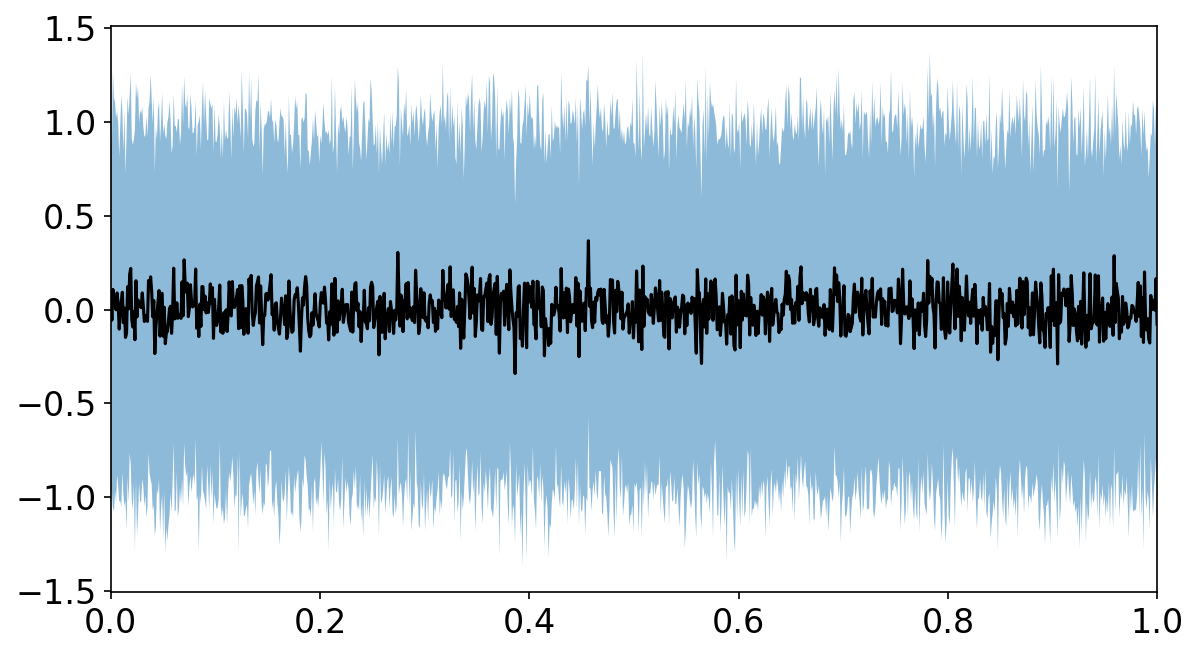

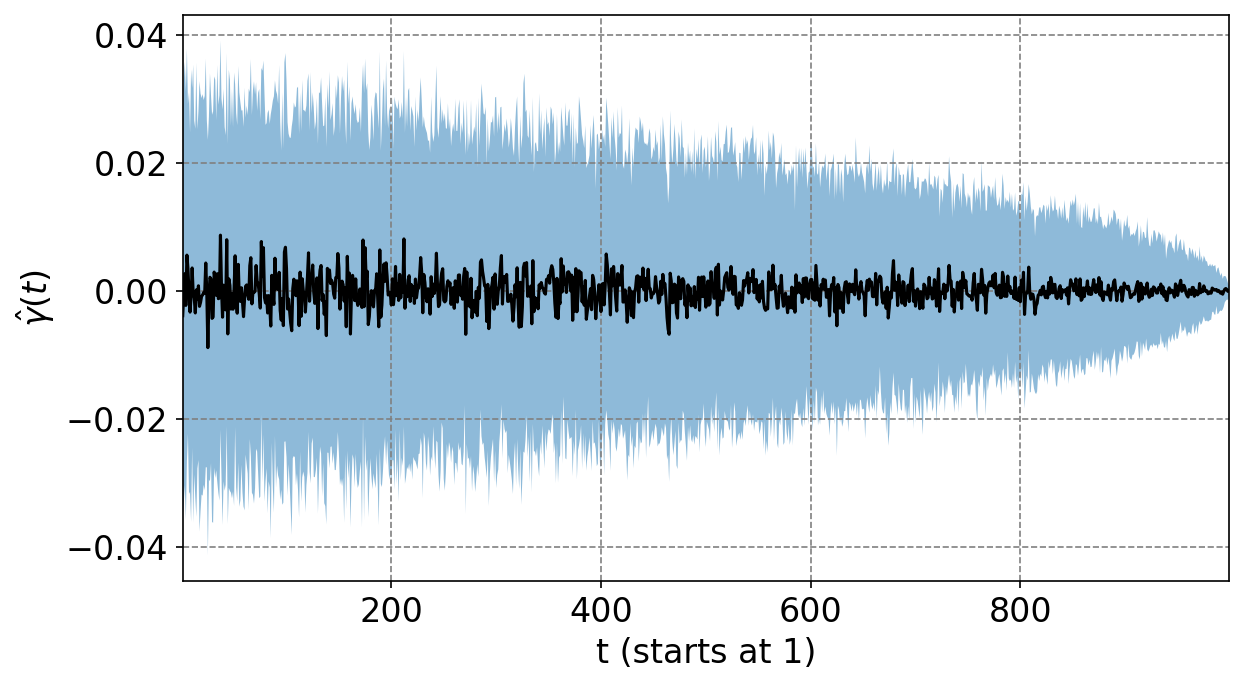

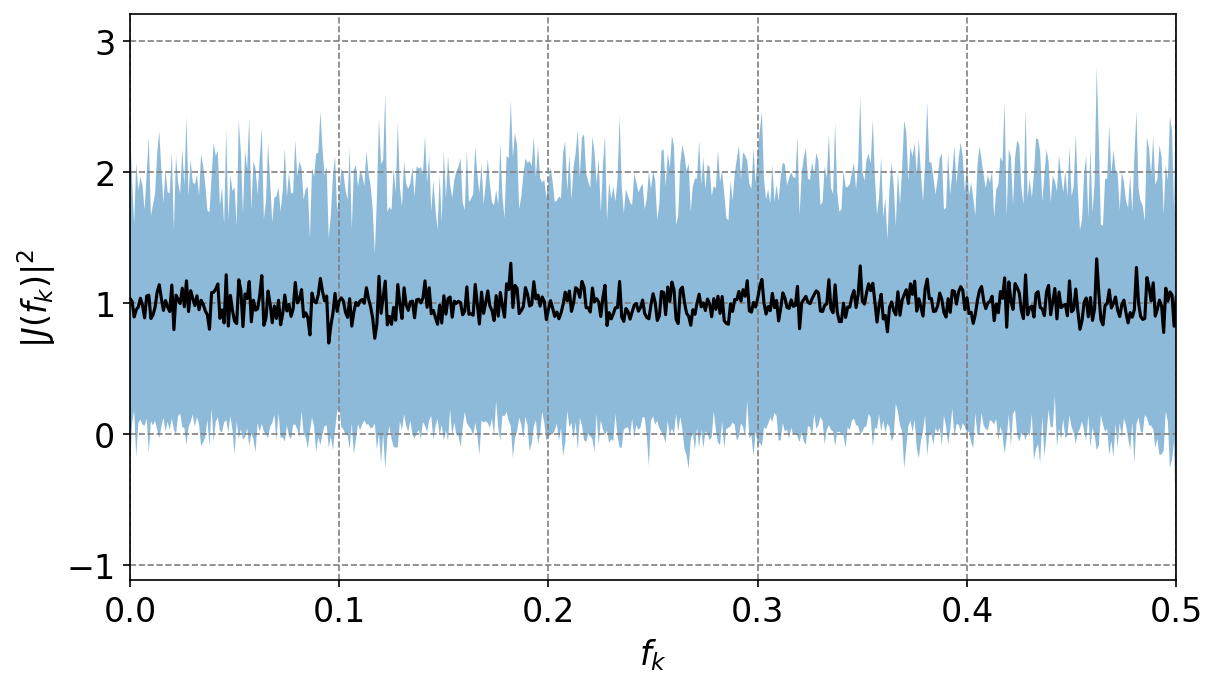

In [ ]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
nb_sim = 100
N = 1000
periodograms = np.random.normal(size = (nb_sim,N))  # shape (n_trials, n_freqs)
freqs = np.linspace(0, 1, N)
##


fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)




def autocorr(tau):
  if tau==0:
    return (periodograms * periodograms / N).sum(axis=1)
  else:
    return (periodograms[:,:-tau] * periodograms[:,tau:] / N).sum(axis=1)

autocorr_avg = np.array([autocorr(tau).mean() for tau in range(1,N)])
autocorr_std = np.array([autocorr(tau).std() for tau in range(1,N)])

fig, ax = fig_ax(figsize=(9, 5))

ax.plot(range(1,N), autocorr_avg, 'k-')
ax.fill_between(range(1,N), autocorr_avg-autocorr_std, autocorr_avg+autocorr_std, alpha=0.5)
ax.set_xlabel('t (starts at 1)')
ax.set_ylabel('$\hat{\gamma}(t)$')
ax.grid(linestyle='--', color='grey')




f_s = 1
list_fk = f_s * np.arange(N/2 + 1) / N

DFT_sqmod = lambda data,k : np.abs((data * np.exp(-2j * np.pi * k * np.arange(data.shape[1]) / data.shape[1]) / np.sqrt(data.shape[1])).sum(axis=1))**2

DFT_avg = np.array([DFT_sqmod(periodograms, k).mean() for k in range(int(N/2)+1)])
DFT_std = np.array([DFT_sqmod(periodograms, k).std() for k in range(int(N/2)+1)])
print(DFT_avg.mean(), DFT_std.mean())

fig, ax = fig_ax(figsize=(9, 5))

ax.plot(list_fk, DFT_avg, 'k-')
ax.fill_between(list_fk, DFT_avg-DFT_std, DFT_avg+DFT_std, alpha=0.5)
ax.set_xlabel('$f_k$')
ax.set_ylabel('$|J(f_k)|^2$')
ax.grid(linestyle='--', color='grey')


## Question 9

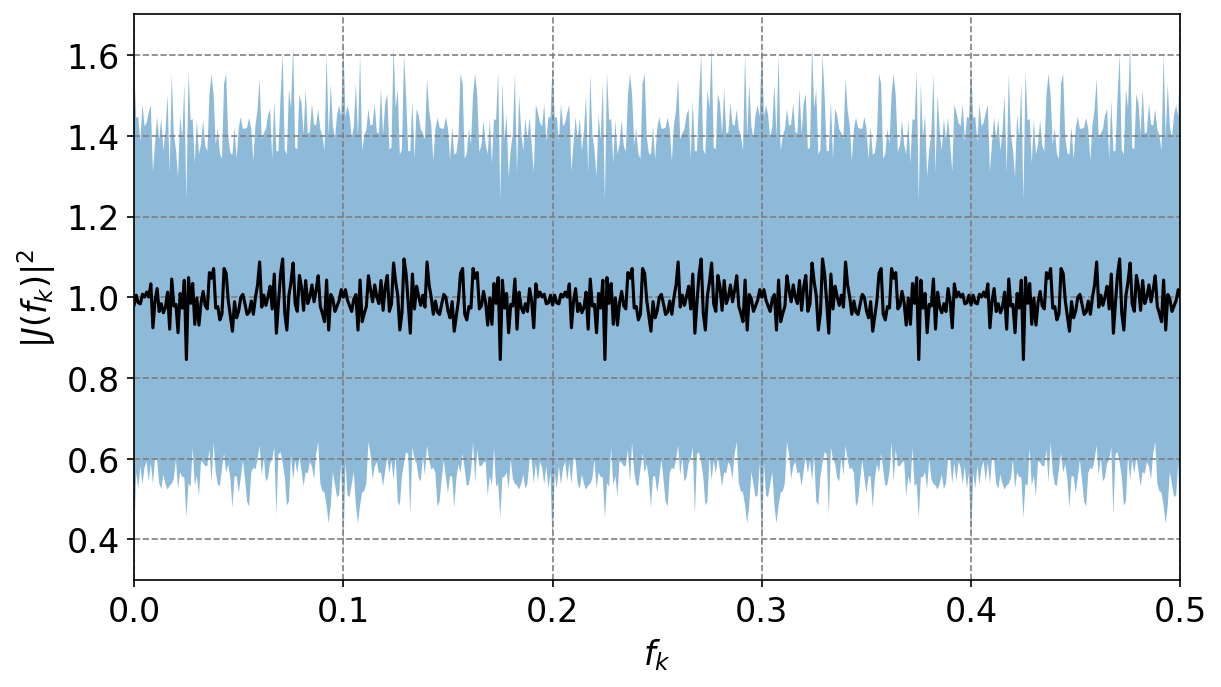

In [ ]:
K = 5
DFT = np.zeros((int(N/2)+1, nb_sim))
for i in range(K):    
    DFT += np.vstack([DFT_sqmod(periodograms[:, i*int(N/K):(i+1)*int(N/K)], k) for k in range(int(N/2)+1)]) / K

fig, ax = fig_ax(figsize=(9, 5))
ax.plot(list_fk, DFT.mean(axis=1), 'k-')
ax.fill_between(list_fk, DFT.mean(axis=1)-DFT.std(axis=1), DFT.mean(axis=1)+DFT.std(axis=1), alpha=0.5)
ax.set_xlabel('$f_k$')
ax.set_ylabel('$|J(f_k)|^2$')
ax.grid(linestyle='--', color='grey')

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [ ]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [ ]:
distance_matrix_train = np.zeros((len(X_train),len(X_train)))

for i in range(len(X_train)):
  for j in range(len(X_train)):
    distance_matrix_train[i,j] = dtw(X_train[i],X_train[j]).distance

distance_matrix_test = np.zeros((len(X_test),len(X_train)))

for i in range(len(X_test)):
  for j in range(len(X_train)):
    distance_matrix_test[i,j] = dtw(X_test[i],X_train[j]).distance

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric="precomputed")
parameters= {'n_neighbors':range(1,10)}

grid = GridSearchCV(knn, parameters, cv=5, scoring=make_scorer(f1_score),n_jobs=-1)
grid.fit(distance_matrix_train,y_train)

print('Best parameter: ', grid.best_params_)
print('Best average f1-score: ', grid.best_score_)

Best parameter:  {'n_neighbors': 5}
Best average f1-score:  0.76999333999334


In [ ]:
grid

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric='precomputed',
                                            n_neighbors=1),
             n_jobs=-1, param_grid={'n_neighbors': range(1, 10)},
             scoring=make_scorer(f1_score))

## Question 11

In [ ]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 5, metric="precomputed")
# Fit the classifier to the data
knn.fit(distance_matrix_train,y_train)

KNeighborsClassifier(metric='precomputed')

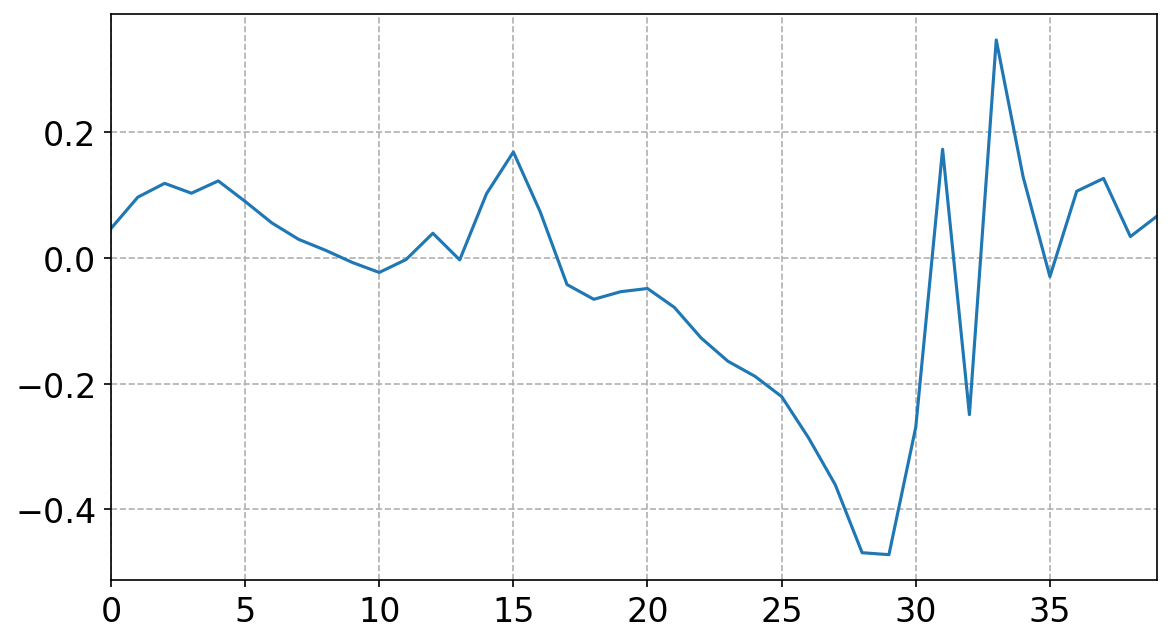

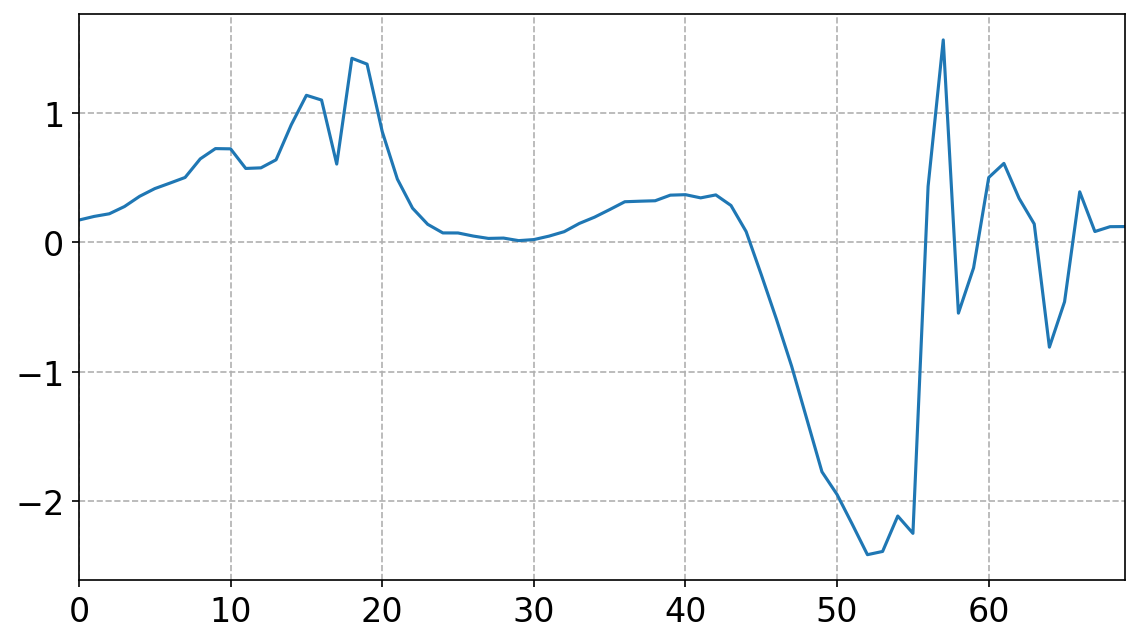

In [ ]:
y_pred = knn.predict(distance_matrix_test)

#Find the indices of the mislabeled data
for i in range(len(y_pred)):
  if y_pred[i] != y_test[i]:
    if y_test[i]== 1:
      bad_healthy_indice = i
    else:
      bad_non_healthy_indice = i

#Plot them
fig_1, ax_1 = fig_ax(figsize=(9, 5))
ax_1.plot(X_test[bad_healthy_indice])
ax_1.grid(linestyle='--')
#fig_1.savefig("bad_healthy.pdf")

fig_2, ax_2 = fig_ax(figsize=(9, 5))
ax_2.plot(X_test[bad_non_healthy_indice])
ax_2.grid(linestyle='--')
#fig_2.savefig("bad_non_healthy.pdf")
